Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Пример данных:

Пропущенные значения:

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 1640 entries, 1688 to 854
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   inter_api_access_duration(sec)  1638 non-null   float64
 1   api_access_uniqueness           1638 non-null   float64
 2   sequence_length(count)          1640 non-null   float64
 3   vsession_duration(min)          1640 non-null   int64  
 4   ip_type                         1640 non-null   object 
 5   num_sessions                    1640 non-null   float64
 6   num_users                       1640 non-null   float64
 7   num_unique_apis                 1640 non-null   float64
 8   classification                  1640 non-null   object 
dtypes: float64(6), int64(1), object(

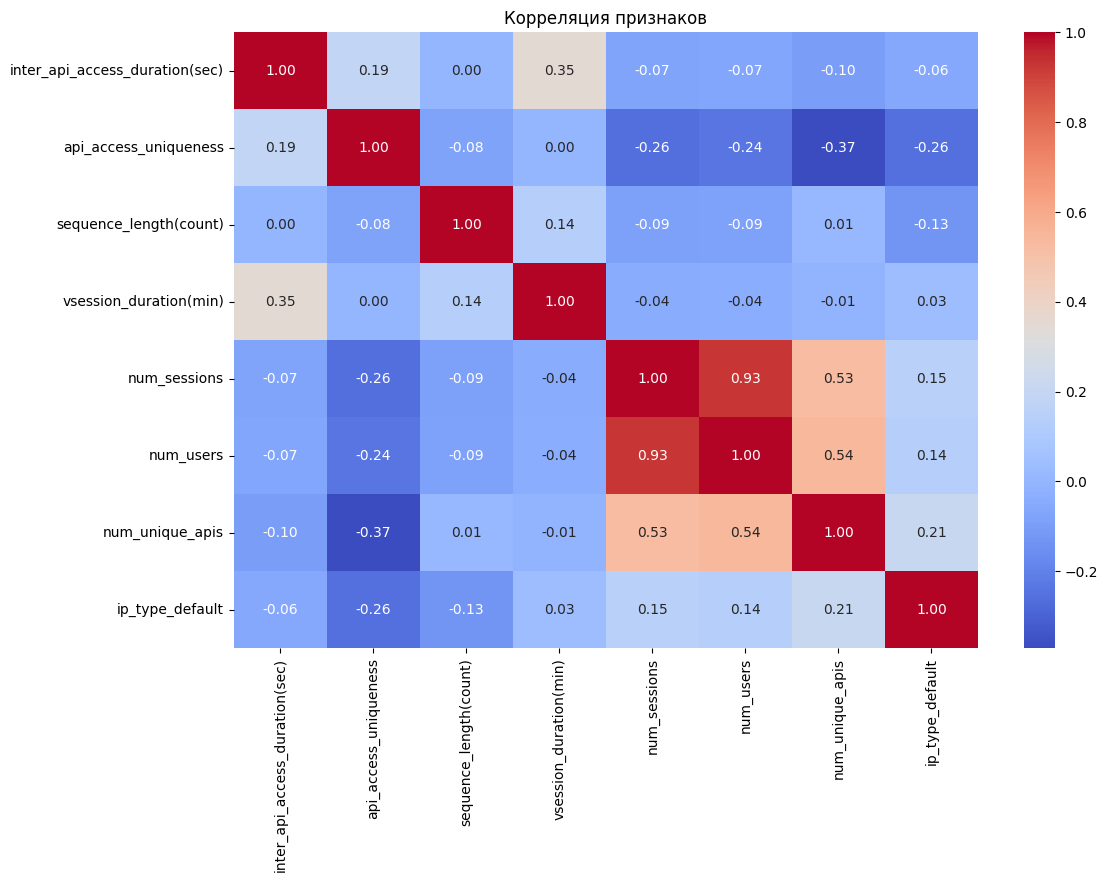

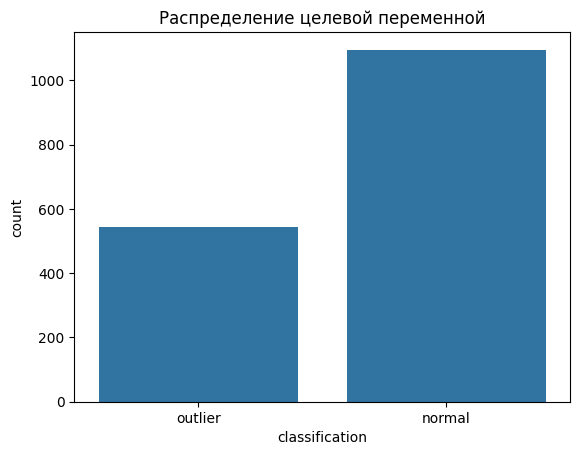


Уникальные значения целевой переменной 'classification': ['outlier' 'normal']

Размер обучающей выборки: (1312, 8)
Размер тестовой выборки: (328, 8)

Распределение классов в обучающей выборке:
classification
normal     879
outlier    433
Name: count, dtype: int64

Распределение классов в тестовой выборке:
classification
normal     216
outlier    112
Name: count, dtype: int64
Accuracy: 0.8014
Precision: 1.0000
Recall: 0.5045
F1-Score: 0.6707


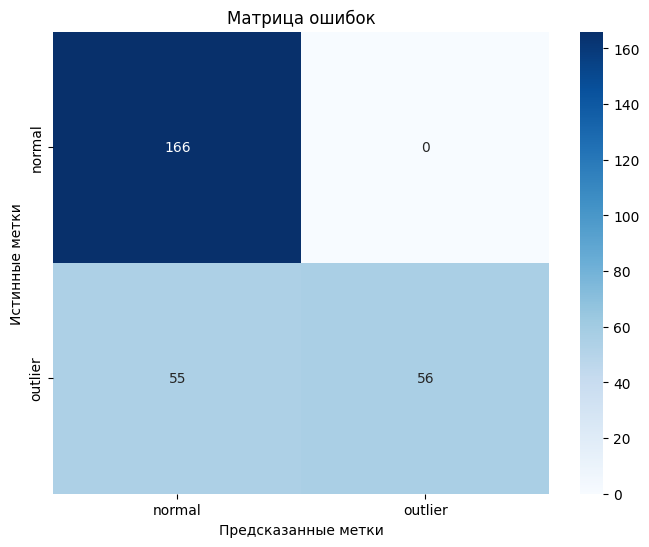

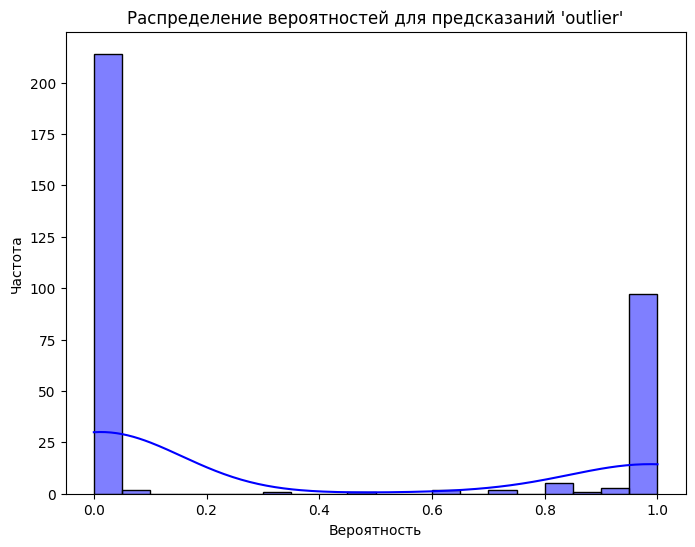

In [5]:
from google.colab import drive
drive.mount('/content/drive')


# Импорт необходимых библиотек для обработки данных и обучения модели
import pandas as pd  # Библиотека для работы с данными (DataFrame)
import numpy as np  # Библиотека для работы с массивами и математическими операциями
import matplotlib.pyplot as plt  # Библиотека для построения графиков
import seaborn as sns  # Библиотека для визуализации данных
from sklearn.model_selection import train_test_split, cross_val_score  # Функции для разделения данных и кросс-валидации
from sklearn.linear_model import LogisticRegression  # Модель логистической регрессии
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Функции для оценки модели
from sklearn.metrics import roc_curve, auc  # Функции для оценки ROC кривой


# Загрузка данных из CSV файла, путь к файлу на Google Drive
file_path = '/content/drive/MyDrive/API.csv'
dataset = pd.read_csv(file_path)  # Читаем CSV файл в DataFrame


# Просмотр первых 5 строк набора данных для первичного ознакомления
print("Пример данных:")
dataset.head()  # Показываем первые 5 строк данных для первичного осмотра


# Проверка на наличие пропущенных значений в данных
missing_data = dataset.isnull().sum()  # Считаем количество пропущенных значений в каждом столбце
print("\nПропущенные значения:")
missing_data  # Выводим количество пропущенных значений для каждого столбца


# Удаление ненужных столбцов из набора данных
dataset = dataset.drop(['Unnamed: 0', '_id', 'source'], axis=1)  # Удаляем ненужные столбцы, чтобы уменьшить размер данных


# Выборка случайных данных (с учетом варианта) для дальнейшей обработки
dataset = dataset.sample(n=1640, random_state=3, replace=True)  # Случайная выборка из данных (с учетом варианта)
dataset.head()  # Печатаем первые 5 строк выборки данных


# Вывод информации о структуре данных, чтобы понять их типы и количество
print("\nИнформация о данных:")
dataset.info()  # Выводим информацию о DataFrame: типы данных и количество ненулевых значений


# Подсчёт дубликатов в наборе данных
duplicates_count = dataset.duplicated().sum()  # Проверяем количество дубликатов в данных
print(f"\nКоличество дубликатов: {duplicates_count}")

# Подсчёт пропущенных значений в наборе данных
missing_values = dataset.isnull().sum()  # Подсчитываем пропущенные значения в данных
print(f"\nПропущенные значения:\n{missing_values}")

# Список столбцов в наборе данных
print("\nСписок столбцов:", dataset.columns.tolist())


# Создание искусственного набора данных для примера
example_df = pd.DataFrame({  # Создаем новый DataFrame с искусственными данными для демонстрации
    'inter_api_access_duration(sec)': np.random.rand(1699),  # Генерация случайных данных для продолжительности доступа
    'api_access_uniqueness': np.random.rand(1699),  # Генерация случайных данных для уникальности доступа
    'sequence_length(count)': np.random.rand(1699),  # Генерация случайных данных для длины последовательности
    'vsession_duration(min)': np.random.rand(1699),  # Генерация случайных данных для продолжительности сессии
    'num_sessions': np.random.randint(1, 9300, 1699),  # Генерация случайных данных для числа сессий
    'num_users': np.random.randint(1, 8500, 1699),  # Генерация случайных данных для числа пользователей
    'num_unique_apis': np.random.randint(0, 525, 1699),  # Генерация случайных данных для числа уникальных API
})

# Функция для поиска выбросов в данных
def find_outliers(df):  # Определяем функцию для поиска выбросов
    outliers_data = {}  # Создаем пустой словарь для хранения данных с выбросами
    # Для каждого числового столбца вычисляется наличие выбросов
    for col in df.select_dtypes(include=np.number).columns:  # Для всех числовых столбцов
        Q1 = df[col].quantile(0.25)  # 25-й процентиль
        Q3 = df[col].quantile(0.75)  # 75-й процентиль
        IQR = Q3 - Q1  # Интерквартильный размах
        lower_limit = Q1 - 1.5 * IQR  # Нижняя граница для выбросов
        upper_limit = Q3 + 1.5 * IQR  # Верхняя граница для выбросов
        outliers_data[col] = df[(df[col] < lower_limit) | (df[col] > upper_limit)]  # Фильтруем выбросы и сохраняем их в словарь

    return outliers_data  # Возвращаем словарь с выбросами

# Поиск выбросов в искусственном наборе данных
outliers_found = find_outliers(example_df)  # Применяем функцию для поиска выбросов в искусственном DataFrame

# Вывод информации о найденных выбросах
for col, outlier in outliers_found.items():  # Для каждого столбца с выбросами
    print(f"Для столбца '{col}' выбросов найдено: {len(outlier)}")

# Удаление выбросов из данных
cleaned_df = example_df.copy()  # Создаем копию DataFrame для удаления выбросов
for col in example_df.select_dtypes(include=np.number).columns:  # Для каждого числового столбца
    Q1 = example_df[col].quantile(0.25)  # 25-й процентиль
    Q3 = example_df[col].quantile(0.75)  # 75-й процентиль
    IQR = Q3 - Q1  # Интерквартильный размах
    lower_limit = Q1 - 1.5 * IQR  # Нижняя граница для выбросов
    upper_limit = Q3 + 1.5 * IQR  # Верхняя граница для выбросов
    cleaned_df = cleaned_df[(cleaned_df[col] >= lower_limit) & (cleaned_df[col] <= upper_limit)]  # Удаляем выбросы


# Обработка пропущенных значений в наборе данных
# Заполнение пропусков средним значением для каждого столбца
for column in ['inter_api_access_duration(sec)', 'api_access_uniqueness', 'sequence_length(count)', 'vsession_duration(min)', 'num_sessions', 'num_users', 'num_unique_apis']:  # Для каждого столбца
    dataset[column] = dataset[column].fillna(dataset[column].mean())  # Заполняем пропущенные значения средним значением столбца

# Проверка после обработки пропусков
print("\nПроверка на пропущенные значения после обработки:")
print(dataset.isnull().sum())  # Выводим количество пропущенных значений после обработки


# Разделение данных на признаки (X) и целевую переменную (y)
X_data = dataset.drop('classification', axis=1)  # Убираем столбец с целевой переменной 'classification' из признаков
y_data = dataset['classification']  # Целевая переменная - столбец 'classification'

# Преобразование категориальных признаков в числовые с помощью one-hot encoding
X_data = pd.get_dummies(X_data, drop_first=True)  # Преобразуем категориальные признаки в числовые переменные с помощью one-hot encoding

# Разделение данных на обучающую и тестовую выборки
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=3)  # Разделяем данные на обучающую и тестовую выборки, 80% для обучения, 20% для тестирования

# Стандартизация признаков для улучшения работы модели
from sklearn.preprocessing import StandardScaler  # Импортируем класс для стандартизации данных
scaler = StandardScaler()  # Создаем объект для стандартизации данных
X_train_scaled_data = scaler.fit_transform(X_train_data)  # Стандартизируем обучающую выборку
X_test_scaled_data = scaler.transform(X_test_data)  # Стандартизируем тестовую выборку


# Проверка корреляции признаков для выявления зависимостей
correlation_matrix = X_data.corr()  # Вычисляем корреляцию между признаками
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # Строим тепловую карту для визуализации корреляций
plt.title("Корреляция признаков")
plt.show()

# График распределения целевой переменной (классов)
sns.countplot(x=y_data)  # Строим график распределения целевой переменной
plt.title("Распределение целевой переменной")
plt.show()

# Количество уникальных значений целевой переменной
print("\nУникальные значения целевой переменной 'classification':", y_data.unique())

# Размеры обучающей и тестовой выборок
print("\nРазмер обучающей выборки:", X_train_data.shape)
print("Размер тестовой выборки:", X_test_data.shape)

# Проверка баланса классов в обучающей и тестовой выборках
print("\nРаспределение классов в обучающей выборке:")
print(y_train_data.value_counts())
print("\nРаспределение классов в тестовой выборке:")
print(y_test_data.value_counts())


# Пример вычисления метрик вручную
y_test_array = np.array(["normal", "normal", "outlier", "normal", "outlier"] * 55 + ["normal", "outlier"])  # Пример истинных меток
y_pred_array = np.array(["normal", "normal", "outlier", "normal", "normal"] * 55 + ["normal", "outlier"])  # Пример предсказанных меток

# Функция для вычисления метрик (точность, полнота, F1-score)
def compute_metrics(y_true, y_pred, positive_class="outlier"):  # Функция для вычисления метрик
    cm = confusion_matrix(y_true, y_pred, labels=["normal", positive_class])  # Вычисляем матрицу ошибок
    TN, FP, FN, TP = cm.ravel()  # Извлекаем значения из матрицы ошибок

    accuracy = (TP + TN) / (TP + TN + FP + FN)  # Расчет точности
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Расчет точности
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Расчет полноты
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # Расчет F1-меры

    return accuracy, precision, recall, f1_score, cm  # Возвращаем вычисленные метрики и матрицу ошибок

# Вычисление метрик
acc, prec, rec, f1, conf_matrix = compute_metrics(y_test_array, y_pred_array)  # Применяем функцию для вычисления метрик

# Вывод метрик
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["normal", "outlier"], yticklabels=["normal", "outlier"])  # Строим матрицу ошибок
plt.title("Матрица ошибок")
plt.xlabel("Предсказанные метки")
plt.ylabel("Истинные метки")
plt.show()


# Обучение модели логистической регрессии
model = LogisticRegression(random_state=3)  # Создаем модель логистической регрессии с фиксированным random_state для воспроизводимости
model.fit(X_train_scaled_data, y_train_data)  # Обучаем модель на обучающих данных

# Предсказание вероятностей для тестовых данных
y_prob = model.predict_proba(X_test_scaled_data)[:, 1]  # Получаем вероятности для положительного класса ("outlier")

# График распределения вероятностей для положительного класса
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=20, kde=True, color='blue')  # Строим гистограмму вероятностей для положительного класса
plt.title("Распределение вероятностей для предсказаний 'outlier'")
plt.xlabel("Вероятность")
plt.ylabel("Частота")
plt.show()

# Оценка модели
y_pred_model = model.predict(X_test_scaled_data)  # Получаем предсказания модели на тестовых данных


